# Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.   

In real-life tasks, there may be many valid ways to approach an analysis task. So basically, we strive to document our approach so that other scientists can understand the decisions we've made.

In [1]:
# import required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from IPython import display

# set plots to be embedded inline
%matplotlib inline

In [2]:
# Enable auto complete in the notebook
# Source : https://stackoverflow.com/questions/36101583/how-to-auto-complete-in-an-ipython-notebook-while-on-ipdb#45089021
# Requirement : !pip install pyreadline , alreay done
%config IPCompleter.greedy=True

In [3]:
# Requires seaborn 0.9.0
# ! pip install seaborn==0.9.0

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood.   

#### Objective
We use this information to cluster the general population into groups with similar demographic properties. Then, we see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

In [5]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [6]:
# Get general demographics data size
azdias.shape

(891221, 85)

In [7]:
# Get a view on the general demographics data
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
# Get feature summary data size
feat_info.shape

(85, 4)

In [9]:
# View on the feature summary data
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
# Create a copy of the original dataframes - We do cleaning on the copies
df_azdias = azdias.copy()



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column.   
We use this file to help you make cleaning decisions during this stage of the project. First of all, we assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [11]:
# Get naturaly missing data as a dataset - for potential further use

# Create a dataframe from the naturally missing data
df_azdias_natural_missing = pd.DataFrame(data=df_azdias.isnull().sum())

# Add a column index
df_azdias_natural_missing = df_azdias_natural_missing.reset_index()

# Set proper column names
df_azdias_natural_missing.rename(columns={'index': 'column_name', 0: 'nb_of_missing'}, inplace=True)

In [12]:
# Get a view of those naturally missing data
df_azdias_natural_missing.head()

,column_name,nb_of_missing
0,AGER_TYP,0
1,ALTERSKATEGORIE_GROB,0
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,4854
4,FINANZ_MINIMALIST,0


In [13]:
# Transform "feat_info" last column: use list type to easily check value in it
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')

In [14]:
# For each of the list created above, ensure to have a list of integer instead of string
for index in feat_info.index:
    sublist_length = len(feat_info.loc[index, 'missing_or_unknown'])
    for indice in range(sublist_length):
        # We could have used conversion to float before to int.
        # But after debug, the exceptions happened only with empty strings
        # so the error catching here is just to be able to continue
        try:
            feat_info.loc[index, 'missing_or_unknown'][indice] = int(feat_info.loc[index, 'missing_or_unknown'][indice])
        except:
            pass
        

In [15]:
# Define: Go through a demographics dataframe and convert codes to missing values according to a feature dictionnary
# Code: Go trough the index of a feature attributes dataframe and get the identified columns and the associated identifiers, one by one
# For each of the corresponding column in the demographics database, replace values by NaN if the identified exist in the column
def missing_code_to_nan(df_demographics, df_feat_attr):
    
    for index in df_feat_attr.index:
        current_column = df_feat_attr.loc[index, 'attribute']
        missing_or_unknown = df_feat_attr.loc[index, 'missing_or_unknown']
        df_demographics[current_column] = df_demographics[current_column].apply(lambda x: np.nan if (x in missing_or_unknown) else x)
        
    return df_demographics

In [16]:
# Code: Convert missing values codes to NaNs
df_azdias = missing_code_to_nan(df_azdias, feat_info)

In [17]:
# Test : We use columns containing -1, 0, or 9 as missing
# We count them in the original dataset in addition to potential existing NaN
# Check against our new dataset after the missing value conversion to NaN
# Testing for the column 'AGER_TYP' which contains 0, -1 converted to NaN
assert (azdias['AGER_TYP'] == 0).sum() + (azdias['AGER_TYP'] == -1).sum() + azdias['AGER_TYP'].isnull().sum() == df_azdias['AGER_TYP'].isnull().sum()

In [18]:
# Testing for the column 'ALTERSKATEGORIE_GROB' which contains 0, -1 and 9 converted to NaN
assert (azdias['ALTERSKATEGORIE_GROB'] == 0).sum() + (azdias['ALTERSKATEGORIE_GROB'] == -1).sum() + (azdias['ALTERSKATEGORIE_GROB'] == 9).sum() + azdias['ALTERSKATEGORIE_GROB'].isnull().sum() == df_azdias['ALTERSKATEGORIE_GROB'].isnull().sum()

In [19]:
# A last testing
assert (azdias['TITEL_KZ'] == 0).sum() + (azdias['TITEL_KZ'] == -1).sum() + azdias['TITEL_KZ'].isnull().sum() == df_azdias['TITEL_KZ'].isnull().sum()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We visualize the distribution of missing value counts to find these columns, identify and document them.    
While some of these columns might have justifications for keeping or re-encoding the data, we just remove them from the dataframe. 

In [20]:
# Get the missing values from the demographics data
df_azdias_missing = pd.DataFrame(data=df_azdias.isnull().sum())

In [21]:
# create an index column
df_azdias_missing = df_azdias_missing.reset_index()

# Set column name for easy usage
df_azdias_missing.rename(columns={'index': 'column_name', 0: 'nb_of_missing'}, inplace=True)

In [22]:
# How many columns have missing data (out of 85) ?
df_azdias_missing.query('nb_of_missing > 0').count()

column_name      61
nb_of_missing    61
dtype: int64

In [23]:
# Restrict the dataset to the 61, for further observation
df_azdias_missing = df_azdias_missing.query('nb_of_missing > 0')

In [24]:
# Get a view on the distribution
df_azdias_missing.describe()

,nb_of_missing
count,61.000000
mean,137277.524590
std,157099.496443
min,2881.000000
25%,93148.000000
50%,99352.000000
75%,116515.000000
max,889061.000000


#### Comment
> At 75%, we are above 100 000. So we restrict our study here to the columns with a number of missing data above 100 0000

In [25]:
# Restricting the dataset to the number of missing above 100 000
df_azdias_missing = df_azdias_missing.query('nb_of_missing > 100000')

In [26]:
# Sort for better visualization
df_azdias_missing = df_azdias_missing.sort_values(by=['nb_of_missing'])

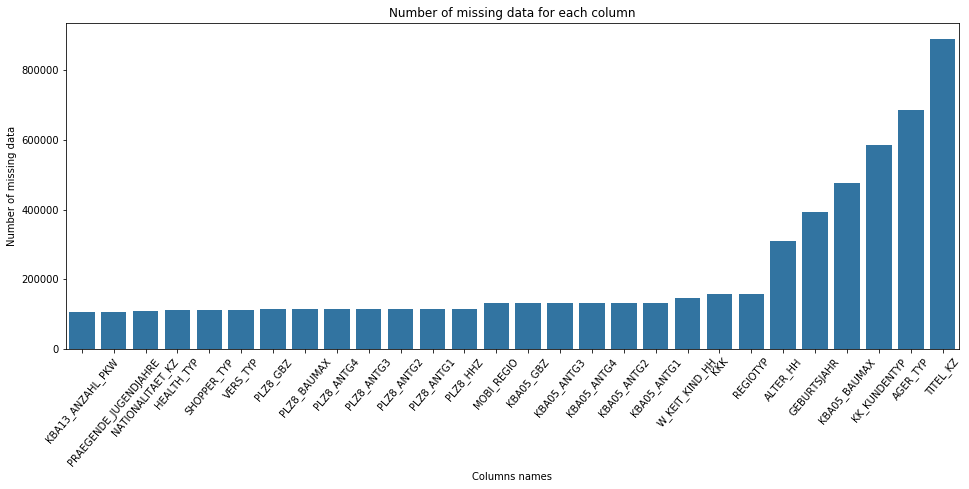

In [27]:
# Find the few outliers, visually
# Set figure size
plt.figure(figsize = [16, 6])

# Plot the values using a single one color
missing_plot = sns.barplot(x = 'column_name', y = 'nb_of_missing', 
                           data = df_azdias_missing, color=sns.color_palette()[0])

# set the titles
missing_plot.set(title='Number of missing data for each column', 
                 xlabel='Columns names', 
                 ylabel='Number of missing data')

# Rotate the column names for better visibility
missing_plot.set_xticklabels(missing_plot.get_xticklabels(), rotation=50);

#### Comment 
> Visually we observe 4 groups. The last one contains the outliers.

In [28]:
# Investigate some treshold values - end of group 1
df_azdias_missing.query('column_name == "PLZ8_HHZ"')

,column_name,nb_of_missing
80,PLZ8_HHZ,116515


In [29]:
# Start of group 2
df_azdias_missing.query('column_name == "MOBI_REGIO"')

,column_name,nb_of_missing
71,MOBI_REGIO,133324


In [30]:
# start of group 3 
df_azdias_missing.query('column_name == "W_KEIT_KIND_HH"')

,column_name,nb_of_missing
48,W_KEIT_KIND_HH,147988


In [31]:
# start of group 4 
df_azdias_missing.query('column_name == "ALTER_HH"')

,column_name,nb_of_missing
43,ALTER_HH,310267


In [32]:
# Remove the outlier columns from the dataset.
# We consider columns in the last group (group 4) as the outliers
df_azdias.drop('ALTER_HH', axis=1, inplace=True)
df_azdias.drop('GEBURTSJAHR', axis=1, inplace=True)
df_azdias.drop('KBA05_BAUMAX', axis=1, inplace=True)
df_azdias.drop('KK_KUNDENTYP', axis=1, inplace=True)
df_azdias.drop('AGER_TYP', axis=1, inplace=True)
df_azdias.drop('TITEL_KZ', axis=1, inplace=True)

In [33]:
# Assert the number of column
assert df_azdias.shape[1] == 79

#### Discussion 1.1.2: Assess Missing Data in Each Column
> Visualy, we identified 4 groups. The columns in the last group are considered outliers. `ALTER_HH`, which is the first of them. It contains 310 267 missing values.   
So the columns we removed are :
- `ALTER_HH`: Birth date of head of household
- `GEBURTSJAHR`: Year of birth.
- `KBA05_BAUMAX`: Most common building type within the microcell
- `KK_KUNDENTYP`: Consumer pattern over past 12 months
- `AGER_TYP`: Best-ager typology.
- `TITEL_KZ`: Academic title flag

Does the missing of those values affect the grouping we are heading to ? It is not that clear at this step and will asessed again futher. But clearly, `KK_KUNDENTYP`: Consumer pattern over past 12 months, seems to be an important column.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we might have some groups of points that have a very different numbers of missing values. We divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We select at least five of these columns and compare the distribution of values.

Depending on what we observe in the comparison, we will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

In [34]:
# Number of data missing in each row
df_azdias_row_missing = pd.DataFrame(data=df_azdias.isnull().sum(axis=1))

In [35]:
# Set column name for easy usage
df_azdias_row_missing.rename(columns={0: 'nb_of_missing'}, inplace=True)

In [36]:
# Get a view on the dataset
df_azdias_row_missing.tail()

,nb_of_missing
891216,3
891217,4
891218,5
891219,0
891220,0


In [37]:
# Get the statistics
df_azdias_row_missing.describe()

,nb_of_missing
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


In [38]:
# How is the distribution especially above 3 ?
df_azdias_row_missing.query('nb_of_missing > 3').describe()

,nb_of_missing
count,206719.000000
mean,23.756050
std,18.084151
min,4.000000
25%,7.000000
50%,15.000000
75%,43.000000
max,49.000000


In [39]:
# Merge the number of missing rows with the demographic dataset
df_azdias = df_azdias.merge(df_azdias_row_missing, left_index=True, right_index=True)

In [40]:
# Divide the data into two subsets based on the number of missing values in each row.
# Subset 1: rows with number of missing values <= 3
# Subset 2: rows with number of missing values > 3

df_azdias_below = df_azdias.query('nb_of_missing <= 3').copy()
df_azdias_above = df_azdias.query('nb_of_missing > 3').copy()

In [41]:
# Remove 'nb_of_missing' columns
df_azdias_below.drop('nb_of_missing', axis=1, inplace=True)
df_azdias_above.drop('nb_of_missing', axis=1, inplace=True)
df_azdias.drop('nb_of_missing', axis=1, inplace=True)

In [42]:
# Check the size
assert df_azdias_below.shape[0] + df_azdias_above.shape[0] == df_azdias.shape[0]
assert df_azdias_below.shape[1] == df_azdias.shape[1]
assert df_azdias_above.shape[1] == df_azdias.shape[1]

In [43]:
# Compare the distribution of values for a column where there are
# no or few missing values, between the two subsets. 
def compare_column_distribution(column_name, dataset_below, dataset_above):
    fig = plt.figure(figsize = [16, 6])
    
    fig.add_subplot(1, 2, 1)
    below_visu = sns.countplot(data = dataset_below, x = column_name, color=sns.color_palette()[0])
    below_visu.set(title=column_name + ' codes frequencies - Below threshold', 
                 xlabel='Unique codes values', 
                 ylabel='Code frequencies')
    
    fig.add_subplot(1, 2, 2)
    above_visu = sns.countplot(data = dataset_above, x = column_name, color=sns.color_palette()[1])
    above_visu.set(title=column_name + ' codes frequencies - Above threshold', 
                 xlabel='Unique codes values', 
                 ylabel='Code frequencies');
    return

In [44]:
# Which columns do we use to compare the distribution ?
# Whe choose some of the ones with zero missing values
for column_name, number_of_missing in df_azdias.isnull().sum().items():
    if number_of_missing == 0:
        print(column_name)

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


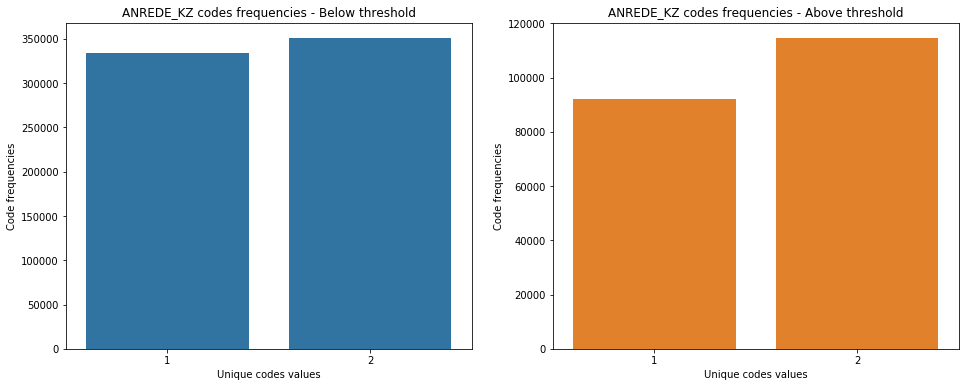

In [45]:
# Compagre ANREDE_KZ
compare_column_distribution('ANREDE_KZ', df_azdias_below, df_azdias_above)

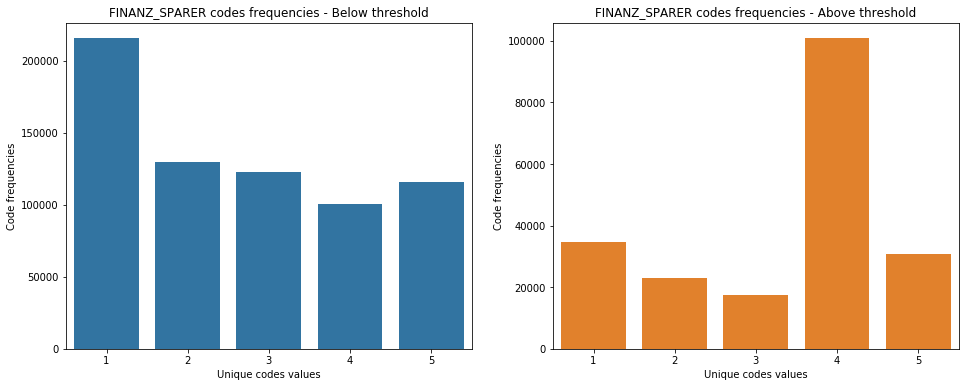

In [46]:
# Compagre FINANZ_SPARER
compare_column_distribution('FINANZ_SPARER', df_azdias_below, df_azdias_above)

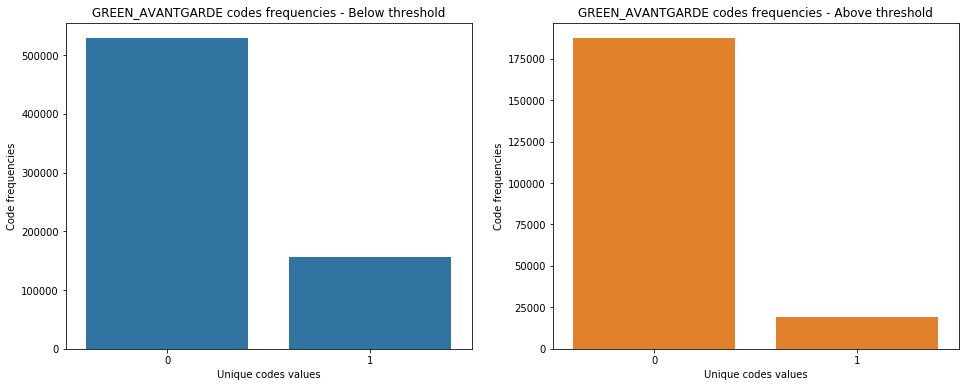

In [47]:
# Compagre GREEN_AVANTGARDE
compare_column_distribution('GREEN_AVANTGARDE', df_azdias_below, df_azdias_above)

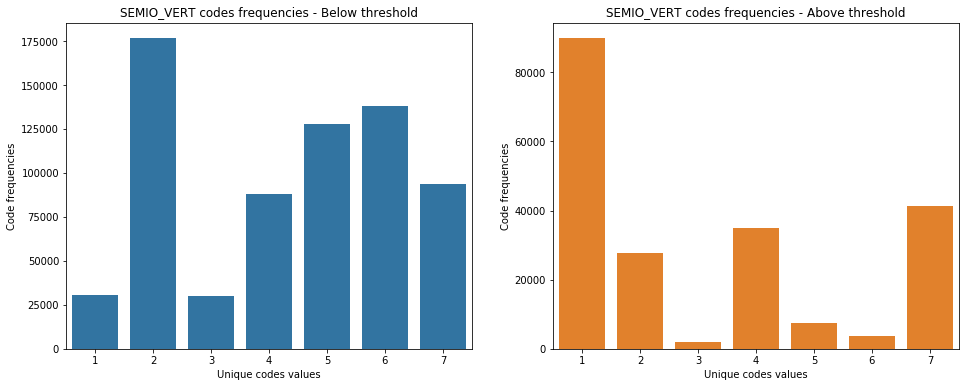

In [48]:
# Compagre SEMIO_VERT
compare_column_distribution('SEMIO_VERT', df_azdias_below, df_azdias_above)

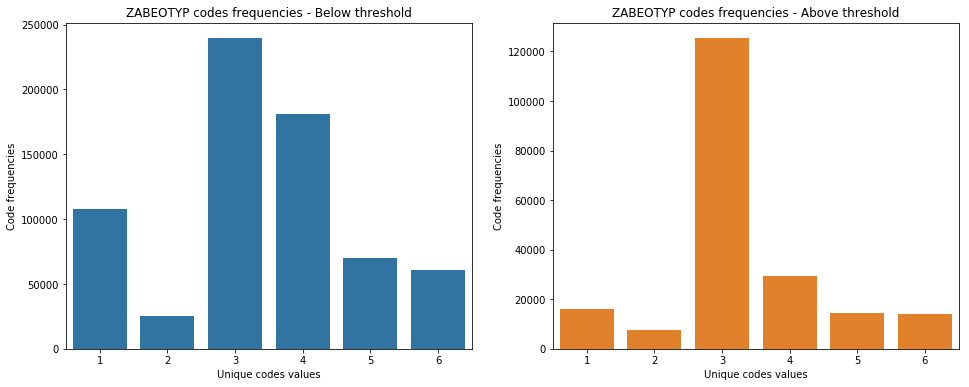

In [49]:
# Compagre ZABEOTYP
compare_column_distribution('ZABEOTYP', df_azdias_below, df_azdias_above)

#### Discussion 1.1.3: Assess Missing Data in Each Row
> Out of 5 columns code frequencies visualization, the distribution seems different for 2 columns:
- `FINANZ_SPARER`: money saver, from very high to very low. The difference is mainly regarding the value '4', which is high for the distribution "Above the threshold" and low when were are "Below threshold". As '4' here means 'low', let's keep that in mind.
- `SEMIO_VERT`: dreamful personality, from lowest to highest affinity. Intuitively, this parameter might not be that important for the grouping we are heading to. Anyway, we keep that in mind for the next steps.   

> Consequently, we keep our threshold at 3, and continue with the values below the threshold. Also, below 3, we have 684502 lines, which is 77% of all the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. We check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling will be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we keep, drop, or re-encode each. Then, in the last part, we create a new data frame with only the selected and engineered columns.

In [50]:
# Observe the features dataset
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [51]:
# How many features are there of each data type?

# Get the unique list of the features
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [52]:
# Number of 'categorical' features 
feat_info.query('type == "categorical"').shape[0]

21

In [53]:
# Number of 'ordinal' features 
feat_info.query('type == "ordinal"').shape[0]

49

In [54]:
# Number of 'numeric' features 
feat_info.query('type == "numeric"').shape[0]

7

In [55]:
# Number of 'mixed' features 
feat_info.query('type == "mixed"').shape[0]

7

In [56]:
# Number of 'mixed' features 
feat_info.query('type == "interval"').shape[0]

1

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we need to encode the levels as dummy variables. We perform one of the following:
- For binary (two-level) categoricals that take numeric values, we keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), wechoose to encode the values using multiple dummy variables .

In [57]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get the categorical features
categorical_features = feat_info.query('type == "categorical"').attribute

In [58]:
# For each categorical feature, get the number of unique values in the demographics dataset
# Create a a dictionary for azdias categorical features
azdias_categorical_features = {}

for a_feature in categorical_features:
    # Because of the previous cleaning, some features are missing
    # So we just print out for verification and continue
    try:
        # Fill the dictionary with the categorical feature identified
        azdias_categorical_features[a_feature] = df_azdias_below[a_feature].nunique()
    except KeyError as ke:
        print("Feature not present anymore in Azdias : " + a_feature)

Feature not present anymore in Azdias : AGER_TYP
Feature not present anymore in Azdias : TITEL_KZ
Feature not present anymore in Azdias : KK_KUNDENTYP


In [59]:
# print the dicitonary
print(azdias_categorical_features)

{'ANREDE_KZ': 2, 'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'GREEN_AVANTGARDE': 2, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'SOHO_KZ': 2, 'VERS_TYP': 2, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'OST_WEST_KZ': 2, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}


In [60]:
# Which binary does not take numeric values ? - knowing the binaries as show above
for column_name in ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']:
    print(column_name)
    print(df_azdias_below[column_name].unique())

ANREDE_KZ
[2 1]
GREEN_AVANTGARDE
[0 1]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[ 2.  1.]
OST_WEST_KZ
['W' 'O']


In [61]:
# OST_WEST_KZ is the Building location via former East / West Germany (GDR / FRG)
# Currently it used NaN: unknown, O: East (GDR), W: West (FRG)
# We choose 1 for West and 0 for East
def binary_to_numeric(row):
    numeric_value = None
    if row['OST_WEST_KZ'] == 'W':
        numeric_value = 1
    if row['OST_WEST_KZ'] == 'O':
        numeric_value = 0
    
    return numeric_value

In [62]:
# Re-encode OST_WEST_KZ
df_azdias_below['OST_WEST_KZ'] = df_azdias_below.apply(binary_to_numeric, axis=1)

In [63]:
# Check
df_azdias_below['OST_WEST_KZ'].dtypes, df_azdias_below['OST_WEST_KZ'].unique()

(dtype('int64'), array([1, 0]))

In [64]:
# Remove OST_WEST_KZ from the dictionnary
del azdias_categorical_features['OST_WEST_KZ']

In [65]:
# Remove 'CAMEO_DEU_2015' colum from the dataset
df_azdias_below.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [66]:
# Consequently remove it also from our list
del azdias_categorical_features['CAMEO_DEU_2015']

In [67]:
# Check
assert df_azdias_below.shape[1] == 78

In [68]:
# Binaries are processed, so remove them from the dictionary
del azdias_categorical_features['ANREDE_KZ']
del azdias_categorical_features['GREEN_AVANTGARDE']
del azdias_categorical_features['SOHO_KZ']
del azdias_categorical_features['VERS_TYP']

In [69]:
# Visual verification
azdias_categorical_features

{'CJT_GESAMTTYP': 6,
 'FINANZTYP': 6,
 'GFK_URLAUBERTYP': 12,
 'LP_FAMILIE_FEIN': 11,
 'LP_FAMILIE_GROB': 5,
 'LP_STATUS_FEIN': 10,
 'LP_STATUS_GROB': 5,
 'NATIONALITAET_KZ': 3,
 'SHOPPER_TYP': 4,
 'ZABEOTYP': 6,
 'GEBAEUDETYP': 7,
 'CAMEO_DEUG_2015': 9}

In [70]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Code: For each column, we create the dummies, join them to the dataset and then delete the column
for column, level in azdias_categorical_features.items():
    dummies_values = pd.get_dummies(df_azdias_below[column], prefix=column)
    df_azdias_below = df_azdias_below.join(dummies_values)
    df_azdias_below.drop(column, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features
> - Binary categoricals: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ    
> - Multi-level categoricals: CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015   

> To keep things straightforward, we decided to drop the categorical CAMEO_DEU_2015. It has too many features.    
> We identified OST_WEST_KZ as the binary column that does not take numerical values and re-encode it. We chose 1 for West and 0 for East.   
> We encode all the remaining columns using dummies. Algo: For each column, we create the dummies, join them to the dataset and then delete the column.   


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve our attention :
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

We use `Data_Dictionary.md` for the details about the features.

In [71]:
# Get the "mixed" features
mixed_features = feat_info.query('type == "mixed"').attribute

In [72]:
# Restrict to the ones we have on azdias dataset
azdias_mixed_features = []

for a_feature in mixed_features:
    if (a_feature in df_azdias_below.columns):
        azdias_mixed_features.append(a_feature)

In [73]:
# List the "mixed" features in azdias dataset
azdias_mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [74]:
# "PRAEGENDE_JUGENDJAHRE_D" will be the column for decade
# Create a dictionary for the values. The choices are made based on the data dictionary file
decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

In [75]:
# "PRAEGENDE_JUGENDJAHRE_M" will be the binary column for movement
# Create a dictionary for the values. The choices are made based on the data dictionary file
# We choose 1 for maintream and 0 for avantgarde
movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

In [76]:
# Add a new column and fill NaN : 'PRAEGENDE_JUGENDJAHRE_D'
df_azdias_below['PRAEGENDE_JUGENDJAHRE_D'] = np.nan

In [77]:
# Define : We go through the current column and fill the new column according to the values we find, 
# and using the dictionary

# Code: For each value in the current column, use the dictionary 
# to fill the new column.
def engineer_praegende_d(row):
    value = None
    previous_value = row['PRAEGENDE_JUGENDJAHRE']
    if previous_value in decade_dict:
        value = decade_dict[previous_value]
        
    return value

In [78]:
# Engineer the new decade column
df_azdias_below['PRAEGENDE_JUGENDJAHRE_D'] = df_azdias_below.apply(engineer_praegende_d, axis=1)

In [79]:
# Visually check the new unique values
df_azdias_below['PRAEGENDE_JUGENDJAHRE_D'].unique()

array([ 90.,  70.,  50.,  80.,  60.,  nan,  40.])

In [80]:
# Add a new column and fill NaN : 'PRAEGENDE_JUGENDJAHRE_M'
df_azdias_below['PRAEGENDE_JUGENDJAHRE_M'] = np.nan

In [81]:
# Define : We go through the current column and fill the new column according to the values we find, 
# and using the dictionary

# Code: For each value in the current column, use the dictionary - movement_dict
# to fill the new column.
def engineer_praegende_m(row):
    value = None
    previous_value = row['PRAEGENDE_JUGENDJAHRE']
    if previous_value in movement_dict:
        value = movement_dict[previous_value]
        
    return value

In [82]:
# Engineer the new movement column
df_azdias_below['PRAEGENDE_JUGENDJAHRE_M'] = df_azdias_below.apply(engineer_praegende_m, axis=1)

In [83]:
# Visually check the new unique values
df_azdias_below['PRAEGENDE_JUGENDJAHRE_M'].unique()

array([  1.,   0.,  nan])

In [84]:
# Delete the 'PRAEGENDE_JUGENDJAHRE' column, as not needed anymore
df_azdias_below.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [85]:
# Add "CAMEO_INTL_2015_W" column for Wealth
df_azdias_below['CAMEO_INTL_2015_W'] = np.nan

In [86]:
# Fill the column
# Define : extract the 'tens'-place raw value from the current one

# Code: get the current value, calculate the 'ones'-place 
def engineer_cameo_w(row):
    value = None
    previous_value = row['CAMEO_INTL_2015']
    if not(previous_value is np.nan):
        value = int(previous_value) - (int(previous_value) % 10)
        
    return value

In [87]:
# Engineer the new wealth column
df_azdias_below['CAMEO_INTL_2015_W'] = df_azdias_below.apply(engineer_cameo_w, axis=1)

In [88]:
# Visually check the new unique values
df_azdias_below['CAMEO_INTL_2015_W'].unique()

array([ 50.,  20.,  40.,  10.,  30.,  nan])

In [89]:
# Add "CAMEO_INTL_2015_LS" column for Life Style
df_azdias_below['CAMEO_INTL_2015_LS'] = np.nan

In [90]:
# Fill the column
# Define : extract the 'ones'-place raw value from the current one

# Code: get the current value, calculate the 'ones'-place 
def engineer_cameo_ls(row):
    value = None
    previous_value = row['CAMEO_INTL_2015']
    if not(previous_value is np.nan):
        value = (int(previous_value) % 10)
        
    return value

In [91]:
# Engineer the new life style column
df_azdias_below['CAMEO_INTL_2015_LS'] = df_azdias_below.apply(engineer_cameo_ls, axis=1)

In [92]:
# Visually check the new unique values
df_azdias_below['CAMEO_INTL_2015_LS'].unique()

array([  1.,   4.,   3.,   2.,   5.,  nan])

In [93]:
# Delete the 'CAMEO_INTL_2015' column, as not needed anymore
df_azdias_below.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

> "PRAEGENDE_JUGENDJAHRE": converted to "PRAEGENDE_JUGENDJAHRE_D" as the column for decade, and "PRAEGENDE_JUGENDJAHRE_M" as the column for movement. Each of them has been populated based on a specific dictionary, and according to the information in Data_Dictionary.md.   
> "CAMEO_INTL_2015": converted to 'CAMEO_INTL_2015_W' for Wealth and 'CAMEO_INTL_2015_LS' for lifestyle.   
- 'CAMEO_INTL_2015_W': to calculate the 'tens'-place, we use x - (x %10)     
- 'CAMEO_INTL_2015_LS': to calculate the 'ones'-place, we use x %10     
At the end of each new features engineering, we deleted the previous column.

#### Step 1.2.3: Complete Feature Selection

As a wrap-up for this step: we made sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe consists of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

For any new columns that we have engineered, we've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. 

#### Comment
> `df_azdias_below` is the subset with few or no missing values. The old or original columns have been deleted during each of the previous engineering steps.  

### Step 1.3: Create a Cleaning Function

Looking ahead to the future, we'll need to perform the same cleaning steps on the customer demographics data. Here, we create the function below to execute the main feature selection, encoding, and re-engineering steps we performed above. 

In [94]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = missing_code_to_nan(df, feat_info)
    
    # remove selected columns 
    df.drop('ALTER_HH', axis=1, inplace=True)
    df.drop('GEBURTSJAHR', axis=1, inplace=True)
    df.drop('KBA05_BAUMAX', axis=1, inplace=True)
    df.drop('KK_KUNDENTYP', axis=1, inplace=True)
    df.drop('AGER_TYP', axis=1, inplace=True)
    df.drop('TITEL_KZ', axis=1, inplace=True)
    
    # remove selected rows
    # Get the missings on the rows
    df_row_missing = pd.DataFrame(data=df.isnull().sum(axis=1))
    df_row_missing.rename(columns={0: 'nb_of_missing'}, inplace=True)
    # Merge the number of missing rows with the demographic dataset
    df = df.merge(df_row_missing, left_index=True, right_index=True)
    # get the rows with number of missing values <= 3
    df = df.query('nb_of_missing <= 3').copy()
    # remove the temporary columnn
    df.drop('nb_of_missing', axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Re-encode OST_WEST_KZ
    df['OST_WEST_KZ'] = df.apply(binary_to_numeric, axis=1)
    # Remove 'CAMEO_DEU_2015' colum from the dataset
    df.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    # We use azdias_categorical_features : prebuilt dictionary
    # Code: For each column, we create the dummies, join them to the dataset and then delete the column
    for column, level in azdias_categorical_features.items():
        dummies_values = pd.get_dummies(df[column], prefix=column)
        df = df.join(dummies_values)
        #if(column == "GEBAEUDETYP"): print(dummies_values.columns.values) # debug: watch 
        df.drop(column, axis=1, inplace=True)
    
    # Engineer mixed-type features
    # Add a new column and fill NaN : 'PRAEGENDE_JUGENDJAHRE_D'
    df['PRAEGENDE_JUGENDJAHRE_D'] = np.nan
    # Engineer the new decade column
    df['PRAEGENDE_JUGENDJAHRE_D'] = df.apply(engineer_praegende_d, axis=1)
    # Add a new column and fill NaN : 'PRAEGENDE_JUGENDJAHRE_M'
    df['PRAEGENDE_JUGENDJAHRE_M'] = np.nan
    # Engineer the new movement column
    df['PRAEGENDE_JUGENDJAHRE_M'] = df.apply(engineer_praegende_m, axis=1)
    # Delete the 'PRAEGENDE_JUGENDJAHRE' column, as not needed anymore
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Add "CAMEO_INTL_2015_W" column for Wealth
    df['CAMEO_INTL_2015_W'] = np.nan
    # Engineer the new wealth column
    df['CAMEO_INTL_2015_W'] = df.apply(engineer_cameo_w, axis=1)
    # Add "CAMEO_INTL_2015_LS" column for Life Style
    df['CAMEO_INTL_2015_LS'] = np.nan
    # Engineer the new life style column
    df['CAMEO_INTL_2015_LS'] = df.apply(engineer_cameo_ls, axis=1)
    # Delete the 'CAMEO_INTL_2015' column, as not needed anymore
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. We check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, we make sure that we've cleaned the DataFrame of the remaining missing values. We choose to apply an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values.    
- For the actual scaling function, we use a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance, scaling each feature to mean 0 and standard deviation 1.   
- For these classes, we make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time.    
The idea is to apply what we do here to the customer demographics data towards the end of the project.

In [95]:
# 'GEBAEUDETYP' categorical variable does not have the same unique values on general population and customer data
# So get_dummies does not generate the same number of columns
# After investigation, the value 5.0 is missing in the customer data, 
# so the customer dataset will not contain the column 'GEBAEUDETYP_5.0'
# customers['GEBAEUDETYP'].unique() !=  azdias['GEBAEUDETYP'].unique()
# As a consequence we delete the column 'GEBAEUDETYP_5.0'
df_azdias_below.drop('GEBAEUDETYP_5.0', axis=1, inplace=True)

In [96]:
# How many missing values do we still have ?
for column_name, nb_of_missing in df_azdias_below.isnull().sum().items():
    if (nb_of_missing > 0):
        print(column_name + " : " + str(nb_of_missing))

LP_LEBENSPHASE_FEIN : 2
LP_LEBENSPHASE_GROB : 1
W_KEIT_KIND_HH : 18077
ANZ_HAUSHALTE_AKTIV : 2461
ANZ_HH_TITEL : 557
KONSUMNAEHE : 36
BALLRAUM : 403
EWDICHTE : 403
INNENSTADT : 403
GEBAEUDETYP_RASTER : 2
KKK : 38326
REGIOTYP : 38326
KBA13_ANZAHL_PKW : 553
ARBEIT : 3428
ORTSGR_KLS9 : 3358
RELAT_AB : 3428
PRAEGENDE_JUGENDJAHRE_D : 6796
PRAEGENDE_JUGENDJAHRE_M : 6796
CAMEO_INTL_2015_W : 2639
CAMEO_INTL_2015_LS : 2639


In [97]:
# Create imputer 
imputer = Imputer()

# apply it to the dataframe
df_azdias_imputered = pd.DataFrame(imputer.fit_transform(df_azdias_below), columns = df_azdias_below.columns)

In [98]:
# Check : do we still have missings ?
for column_name, nb_of_missing in df_azdias_imputered.isnull().sum().items():
    if (nb_of_missing > 0):
        print(column_name + " : " + str(nb_of_missing))

In [99]:
# Apply feature scaling - create scaler
scaler = StandardScaler()

# transform the dataframe
df_azdias_scalered = scaler.fit_transform(df_azdias_imputered)

In [100]:
# back to a dataframe 
df_azdias_scalered = pd.DataFrame(df_azdias_scalered)

In [101]:
# Set the columns names back
df_azdias_scalered.columns = df_azdias_below.columns

### Discussion 2.1: Apply Feature Scaling
> Missing data: we used Imputer() which is better than the alternative of missing values, even if we do not have that much missing values (regarding the dataset size). Please note that in the current version of sklearn, sklearn.preprocessing.Imputer is deprecated. It is still valid in the version we have here, so we use it. From the most recent version it is recommended to use SimpleImputer from sklearn.impute https://scikit-learn.org/stable/modules/impute.html   
> We use a StandardScaler() instance as suggested, scaling each feature to mean 0 and standard deviation 1  


### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we now apply dimensionality reduction techniques.

- We use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we do not set any parameters (so all components are computed) so there's enough features to see the general trend in variability.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Then, we plot the cumulative or sequential values. Based on what we find, we select a value for the number of transformed features we'll retain for the clustering part of the project.

In [102]:
# remind our dataset size
df_azdias_scalered.shape

(684502, 151)

In [103]:
# create PCA - without any parameters, so all componets are computed
pca = PCA()

# Apply PCA to the data
df_check_pca = pca.fit_transform(df_azdias_scalered)

In [104]:
# Create a dataframe with the ratio of variance for each components
explore_pca = pd.DataFrame(data=pca.explained_variance_ratio_)

In [105]:
# Utility function to plot and observe the cumulative variance 
# Obtained from helper_functions.py
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    # Show variance % only when we have a few number of components
    if (num_components < 40):
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

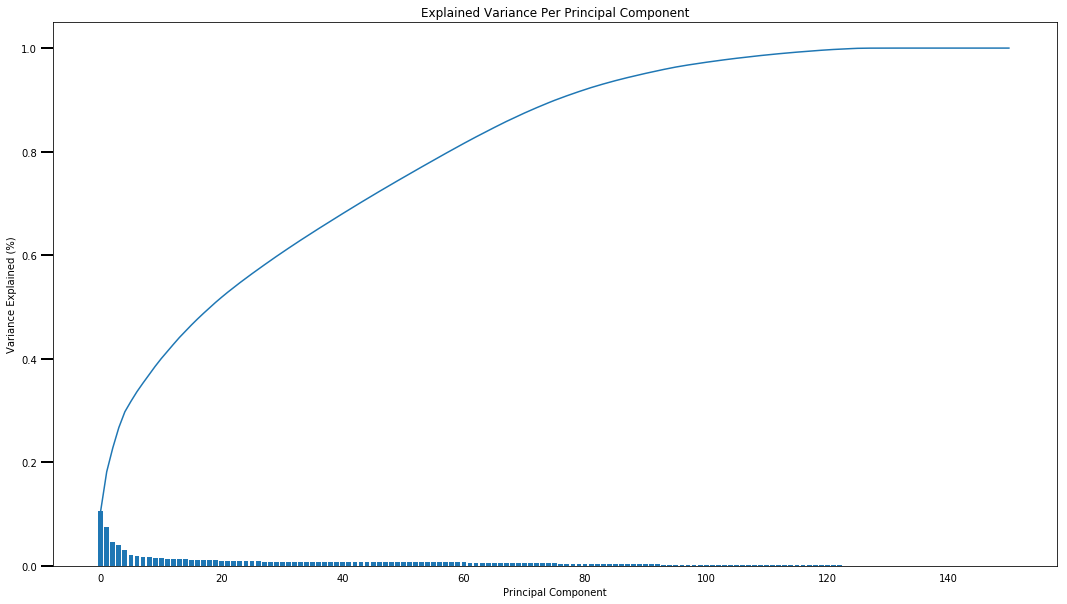

In [106]:
# Observe the variance
scree_plot(pca)

In [107]:
# We retain 35 for the number of transformed features

# Re-fit the PCA
pca = PCA(35)

# Apply PCA to the data
df_azdias_pca = pca.fit_transform(df_azdias_scalered)

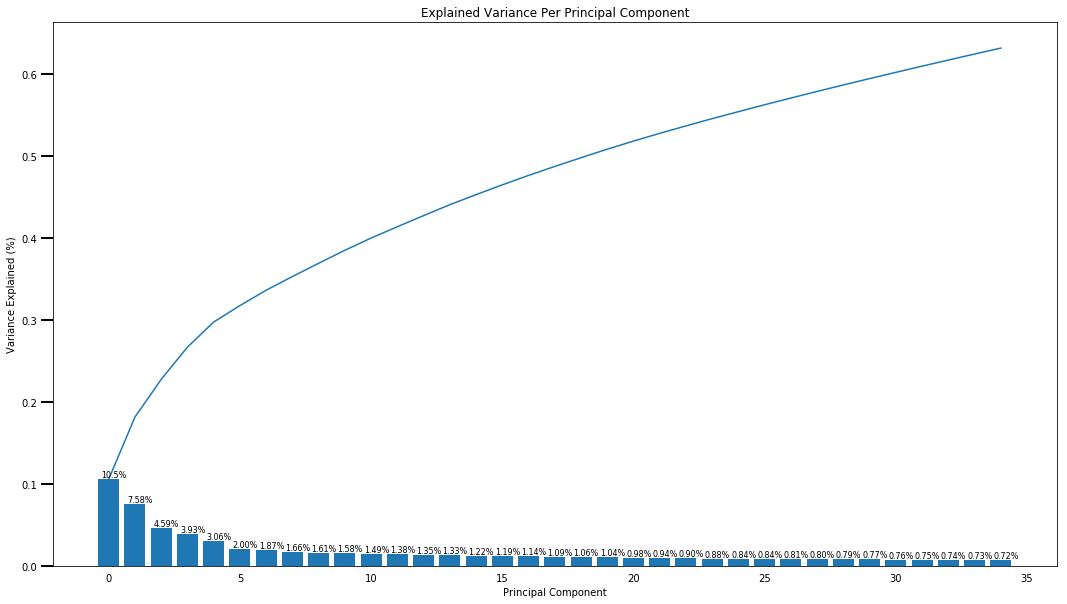

In [108]:
# Observe the variance
scree_plot(pca)

In [109]:
# The variance we got
pca.explained_variance_ratio_.sum()

0.63196018590365222

### Discussion 2.2: Perform Dimensionality Reduction
> PCA Application without any parameters, so all the 152 components are computed: visually, we came out with a number of components around 30, meaning roughtly 60% for the total variance. Then we re-fit the PCA successively with 30, 35 and 40 as number of components, which led us - for the variance - to 59%, 63% and 66% respectively. We decided to stay at 35 components. Indeed, starting from 30 components, the variance trend is stalling until 60, then decreases till 75. So either we stay around 30, or we choose between 60 and 75 components.    
> We made the choice of 35 components.   


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

The principle: each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We use the data dictionary document to understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. 

In [110]:
# The following is based on "pca_results" function from helper_functions.py
# Map weights of the components for corresponding features
# Assciate the linked values, sorted by weight.
def show_feature_weights(df_azdias_scalered, pca, indice):
    # Dimension indexing
    dimensions = dimensions = ['Component-{}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df_azdias_scalered.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create the feature weights and mapping dataframe
    feature_weights = pd.concat([variance_ratios, components], axis = 1)
    
    # Build the line name
    component_name = "Component-" + str(indice)
    
    return feature_weights.loc[component_name].sort_values()

In [111]:
# Get the 1st principal component.
# Print the most interesting features: 3 at the begining, 3 at the end 
print(show_feature_weights(df_azdias_scalered, pca, 1)[:3])
show_feature_weights(df_azdias_scalered, pca, 1)[-3:]

MOBI_REGIO          -0.2020
KBA05_ANTG1         -0.1888
FINANZ_MINIMALIST   -0.1865
Name: Component-1, dtype: float64


PLZ8_ANTG3            0.1783
HH_EINKOMMEN_SCORE    0.1796
LP_STATUS_GROB_1.0    0.1904
Name: Component-1, dtype: float64

In [112]:
# Get the 2nt principal component.
# Print the most interesting features: 3 at the begining, 3 at the end 
print(show_feature_weights(df_azdias_scalered, pca, 2)[:3])
show_feature_weights(df_azdias_scalered, pca, 1)[-3:]

PRAEGENDE_JUGENDJAHRE_D   -0.2347
FINANZ_SPARER             -0.2258
SEMIO_REL                 -0.2217
Name: Component-2, dtype: float64


PLZ8_ANTG3            0.1783
HH_EINKOMMEN_SCORE    0.1796
LP_STATUS_GROB_1.0    0.1904
Name: Component-1, dtype: float64

In [113]:
# Get the 3rd principal component.
# Print the most interesting features: 3 at the begining, 3 at the end 
print(show_feature_weights(df_azdias_scalered, pca, 3)[:3])
show_feature_weights(df_azdias_scalered, pca, 1)[-3:]

ANREDE_KZ    -0.3388
SEMIO_KAEM   -0.3070
SEMIO_DOM    -0.2732
Name: Component-3, dtype: float64


PLZ8_ANTG3            0.1783
HH_EINKOMMEN_SCORE    0.1796
LP_STATUS_GROB_1.0    0.1904
Name: Component-1, dtype: float64

### Discussion 2.3: Interpret Principal Components
> `Component-1`: 10.5% variance    
The largest weight of this component is related to LP_STATUS_GROB_1.0 which expresses the social status, rough scale. This component also positively weights PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) and HH_EINKOMMEN_SCORE (estimated household net income). So increasing the social status for example tend to be associated with an increase of the number of family houses in the PLZ8 region and the estimated household net income. It all make sense. The component is positively influenced by those features, but on the other side is negatively influenced by MOBI_REGIO (Movement patterns), KBA05_ANTG1 (Number of 1-2 family houses in the microcell) and FINANZ_MINIMALIST (Financial typology). Indeed, an increase of one of those features move the others in the same direction, this is all we can at this stage of the analysis. We consider the correlation between those 3 features as an information, which might be useful for the next steps.

> `Component-2`: 7.53% variance   
It has the same largets weight as `component-1`. It is negatively influenced by PRAEGENDE_JUGENDJAHRE_D (dominating movement of person's youth, especially decade), FINANZ_SPARER (financial typology) and SEMIO_REL (personality typology). They have very similar negative values, even if it is not that obvious, we can assume that they are related.

> `Component-3`: 4.56% variance
It has the same largets weight as `component-1`. It is negatively influenced by ANREDE_KZ (gender), SEMIO_KAEM (personality typology) and SEMIO_DOM (which also personality typology). So the gender and the personality typologie are related and moving in the same direction.


> Those 3 components (with highest variances) are all positively impacted by PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), HH_EINKOMMEN_SCORE (estimated household net income) and LP_STATUS_GROB_1.0 which expresses the social status, rough scale. At this stage of our analysis, there seems to be the main features.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. We then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We use this fact to select a final number of clusters in which to group the data.    
- Once we've selected a final number of clusters to use, we re-fit a KMeans instance to perform the clustering operation. 

In [114]:
# Get the PCA-transformed data
df_azdias_pca = pd.DataFrame(df_azdias_pca)

In [115]:
# Obtain the score for each model
def kmeans_score(data, center):
    # Instantiate kmeans
    kmeans = KMeans(n_clusters = center)
    # Fit the model to the data
    model = kmeans.fit(data)
    # Get the score
    score = np.abs(model.score(data))
    return score

In [116]:
# Explore clusters with a defined number of centers
def explore_clusters(data, centers):
    scores = []
    
    for a_center in centers:
        scores.append(kmeans_score(data, a_center))
    
    plt.figure(figsize=(16, 9))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');
    
    return

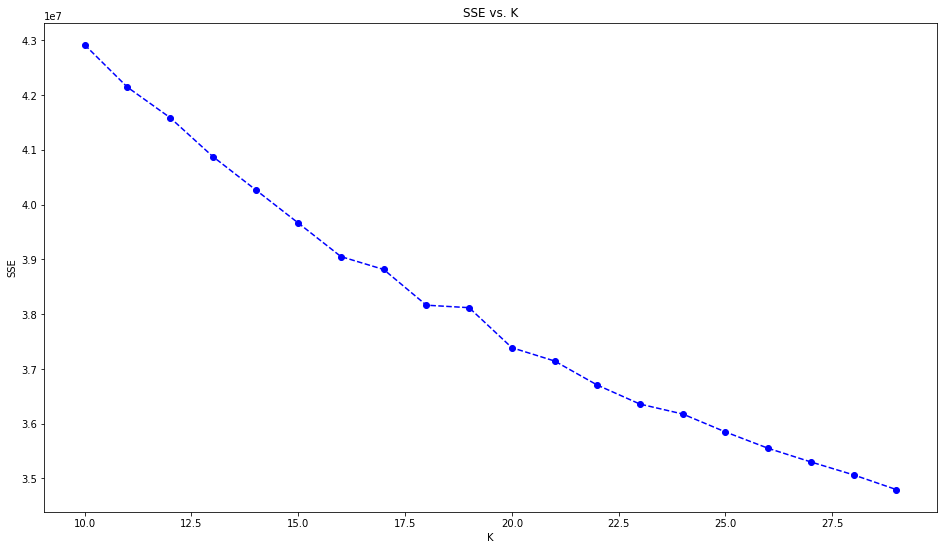

In [117]:
# Now explore the clusters on the PCA-transformed data
explore_clusters(df_azdias_pca, list(range(10, 30)))

In [118]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_selected = KMeans(25)

In [119]:
# Fit the model to the data
model = kmeans_selected.fit(df_azdias_pca)

In [120]:
# Predict to show the categories belonging
labels = model.predict(df_azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

> We've decided to segment the population into 25 clusters.   
Based on the visualization above, the strong leveling off we might have after 25 clusters is not obvious. In fact there is no real leveling off. But as the graph is still decreasing anyway, we consider a potential leveling off after the last number of clusters we have here, so we choose the last one.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters.    
Here, we do not re-fit all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- We apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. We assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.
- We use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we will not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor will we be creating new sklearn objects! We carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [121]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")

In [122]:
# Clean data
customers = clean_data(customers)

In [123]:
# apply the imputer
customers_imputered = pd.DataFrame(imputer.fit_transform(customers), columns = customers.columns)

In [124]:
# Use our scaler
customers_scalered = scaler.fit_transform(customers_imputered)

In [125]:
# back to a dataframe 
customers_scalered = pd.DataFrame(customers_scalered, columns = customers.columns)

In [126]:
# Use the pca
customers_pca = pca.transform(customers_scalered)

In [127]:
# Obtain clusters predictions
customers_labels = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

We consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. 
  - We recall the analysis performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values. If we found that this group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. Indeed, we make sure that we account for the number of data points in this subset, for both the general population and customer datasets, when making the computations
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? we select at least one such cluster and infer what kind of people might be represented by that cluster. we use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, we use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- We perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

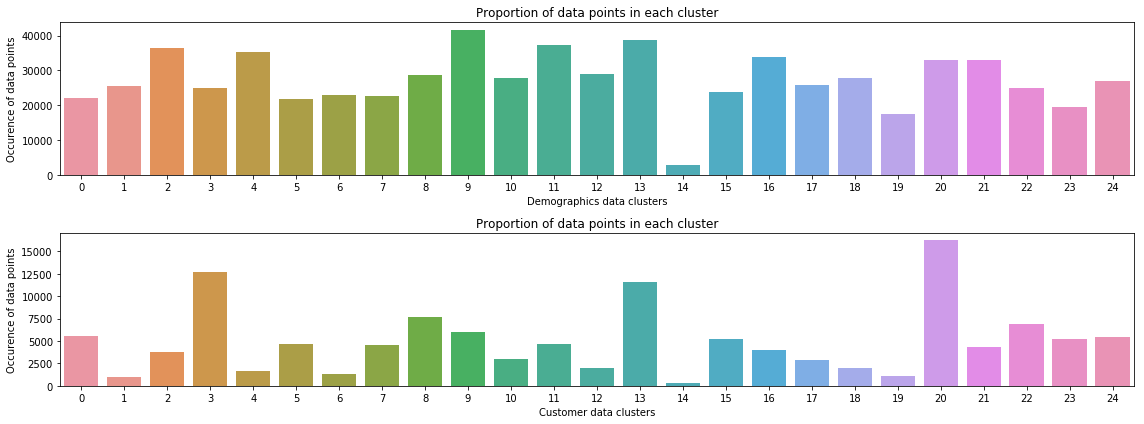

In [140]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure(figsize = [16, 6])

# Prediction for the general population
fig.add_subplot(2, 1, 1)
general_centers = sns.countplot(labels)
general_centers.set(title='Proportion of data points in each cluster', 
                    xlabel='Demographics data clusters', 
                    ylabel='Occurence of data points')

# Prediction for the customers data
fig.add_subplot(2, 1, 2)
customers_centers = sns.countplot(customers_labels)
customers_centers.set(title='Proportion of data points in each cluster', 
                      xlabel='Customer data clusters', 
                      ylabel='Occurence of data points')
fig.tight_layout();

In [143]:
# back to the original data space - customers
# inverse pca
inverse_pca = pca.inverse_transform(model.cluster_centers_)

In [144]:
# inverse scaler
inverse_scaler = scaler.inverse_transform(inverse_pca)

In [146]:
# Reconstruct data
reconstructed_data = pd.DataFrame(inverse_scaler, columns=df_azdias_below.columns)

Sources to understand the way to reconstruct :   
- https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com
- https://stackoverflow.com/questions/49885007/how-to-use-scikit-learn-inverse-transform-with-new-values   
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform   

In [157]:
# Get overrepresented cluster from customers : cluster 3 - top 5
reconstructed_data.loc[3].sort_values().tail()

CAMEO_INTL_2015_W            14.364775
LP_LEBENSPHASE_FEIN          23.828994
PRAEGENDE_JUGENDJAHRE_D      50.342715
KBA13_ANZAHL_PKW            730.333593
MIN_GEBAEUDEJAHR           1992.459458
Name: 3, dtype: float64

In [158]:
# Get overrepresented cluster from customers : cluster 13 - top 5
reconstructed_data.loc[13].sort_values().tail()

CAMEO_INTL_2015_W            17.817134
LP_LEBENSPHASE_FEIN          44.829981
PRAEGENDE_JUGENDJAHRE_D      55.749828
KBA13_ANZAHL_PKW            694.337977
MIN_GEBAEUDEJAHR           1993.182177
Name: 13, dtype: float64

In [159]:
# Get overrepresented cluster from customers : cluster 20 - top 5
reconstructed_data.loc[20].sort_values().tail()

CAMEO_INTL_2015_W            14.316278
LP_LEBENSPHASE_FEIN          45.641969
PRAEGENDE_JUGENDJAHRE_D      58.481583
KBA13_ANZAHL_PKW            753.403268
MIN_GEBAEUDEJAHR           1992.590963
Name: 20, dtype: float64

In [160]:
# Get underrepresented cluster from customers : cluster 4 - top 5
reconstructed_data.loc[4].sort_values().tail()

LP_LEBENSPHASE_FEIN          11.769569
CAMEO_INTL_2015_W            37.888154
PRAEGENDE_JUGENDJAHRE_D      72.624737
KBA13_ANZAHL_PKW            551.005848
MIN_GEBAEUDEJAHR           1992.336827
Name: 4, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

The main questions are : can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?   

- The overrepresented clusters in the customers dataset are the clusters 3, 13 and 20.   
The observation of the top 5 features of those people reveals the same features which are MIN_GEBAEUDEJAHR (First year building was mentioned in the database), KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region), PRAEGENDE_JUGENDJAHRE_D (Dominating movement of person's youth - decades), LP_LEBENSPHASE_FEIN (Life stage, fine scale) and CAMEO_INTL_2015_W (German CAMEO: Wealth typology).   
- The underrepresented clusters in the customers dataset, compared to the general population, are the clusters 4, 6, 10, 12. For the clsuter 4 for example, we have also MIN_GEBAEUDEJAHR (First year building was mentioned in the database), KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region), PRAEGENDE_JUGENDJAHRE_D (Dominating movement of person's youth - decades), LP_LEBENSPHASE_FEIN (Life stage, fine scale) and CAMEO_INTL_2015_W (German CAMEO: Wealth typology).   

- The cluster assignement proportions are not really similar between the company's customer base and the demographics data. So the company's customer base is not universal. Because of those mismatch, there are only particular segments of the population that are interested in the company's products.
- Do we have higher proportion of persons in a cluster for the customer data compared to the general population ? In reality, No, based on the visuals. So it would mean that there are no people in the customer clusters who could be a target audience for the company. Basically it suggests that the people we are looking for here are outside the target demographics.
- It might suggest that the distributions we identified as differents (FINANZ_SPARER - money saver from very high to low and SEMIO_VERT - dreamful personality, from lowest to highest affinity) earlier at the point 1.1.3, are the ones with the target demographics.

In [161]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Identify_Customer_Segments.ipynb'])

0